
**Measuring the Properties of a Transitting Extrasolar Planet**

In this assignment, you will measure the parameters of the light curve of the transit of an extrasolar planet across a star.  We will do this using Bayesian statistical inference.

We will first find the maximum likelihood model parameters.  We will then find the conditional  posteriors for three of the parameters.  Finally, we will find the 2 dimensional posterior marginalized over a third parameter.

The data consists of measured fluxes of a star at different times.  As the planet passes in front of the star there is a dip in the flux.  The important quantities to measure are: 1) What is the baseline flux before and after the transit; 2) How deep the dip is which is related to how large the planet is compared to the star ; 3) How long the transit is which is related to the orbital speed, orbital inclination and the sizes of the star and planet; 4) How steep are the transitions into and out of the transit which is related to the limb darkening of the star combined with the size and speed of the planet.  These will be parameters that will be found from the light curve and later interpreted in terms of physical quantities.



1) First you must import `numpy`, `pandas`, `matplotlib.pyplot` and `scipy.optimize`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

2) Now import the data file "eclipsing_planet_data.csv" into a dataframe.  This file has the measured fluxes, the time of each observation and the estimated errors in each observation.  Put these into separate vectors `t`, `f` and `sigma`.

In [2]:
df = pd.read_csv("eclipsing_planet_data.csv")
df.head()

t = df["time"].values
f = df["flux"].values
sigma = df["sigma"].values

3) Plot time vs flux.  The units are in minutes and arbitrary relative flux units.

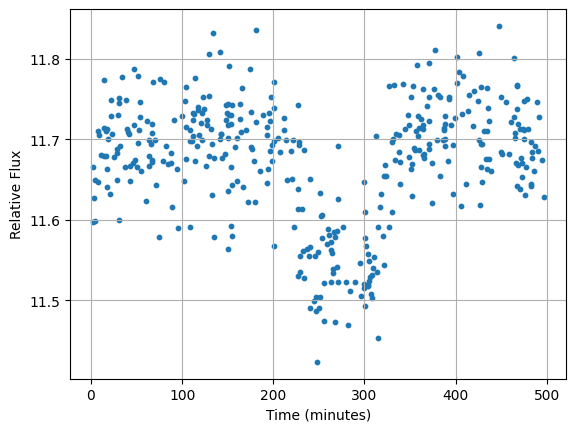

In [3]:
plt.scatter(t, f, s=10)
plt.xlabel('Time (minutes)')
plt.ylabel('Relative Flux')
plt.grid()
plt.show()

4) We must build a model for this light curve.  We will use the model :
    
$ f(t) = f_o - \delta F \exp[ -\frac{|t - to|^n}{(\Delta t)^n}  ]  $ 

The parameters are the baseline flux ($f_o$), the depth of the dip ($\delta F$), the time of the transit ($t_o$), the width of the transit ($\Delta t$) and the parameter $n$ which controls the speed of the drop into the transit.

Write a function that takes first the time, $t$ and then the other parameters and returns the predicted flux.

In [4]:
def light_curve(t, Fo, dF, dt, to, n):
    return Fo - dF * np.exp(-(np.abs(t - to)**n)/(dt**n))

5) We will assume the noise is Gaussian distributed.  We need to make a $\chi^2$ function that we will minimize to find the best fit parameters.

$\chi^2(p) = \sum_i \frac{(f_i - L(t_i,p) )^2}{\sigma_i^2}$

where $L(t_i,p)$ is the model for the lightcurve.  Make a function that returns the $\chi^2$ and takes the parameters as a vector $p$.  These are the same parameters ($f_o$, $\delta F$, $\Delta t$, $t_o$, $n$), but they need to be encoded in a vector to work with the optimizer. Since `t` and `f` are in global memory they can be used inside this function and don't need to be arguments.

Write this $\chi^2(p)$ function.

In [5]:
def chi2(p):
    Fo, dF, dt, to, n = p
    model = light_curve(t, Fo, dF, dt, to, n) 
    return np.sum(((f - model) / sigma) ** 2) 

6) Now we can find the set of parameters that minimises $\chi^2(p)$.  To do this we will use `scipy.optimize`.  In this function use `method = 'Nelder-Mead'`.  You will need to make an initial guess as to what these parameters are.  Look at the data and estimate them.  Check the output of the optimizer.  If it has not converged properly your guess was not good and you should try again (or there is some other problem).  Save the results in `best_fit`. 

Print out the best fit parameters with labels.

In [6]:
guess = np.array([11.7, 0.2, 60, 280, 7]) # looking at the scatter plot
best_fit = minimize(chi2, guess, method='Nelder-Mead')

print('best fit model :')
print('    Fo = ',best_fit.x[0],'flux')
print('    dF = ',best_fit.x[1],' flux')
print('    dt  = ',best_fit.x[2],' mins')
print('    to = ',best_fit.x[3],'  mins')
print('    n = ',best_fit.x[4])


best fit model :
    Fo =  11.702508931927511 flux
    dF =  0.15699620067967907  flux
    dt  =  49.78186992804474  mins
    to =  274.7814052682069   mins
    n =  7.517209768592305


7) Make a new vector of times that is evenly spaced.  Use `light_curve()` to make a model lightcurve with the best-fit parameters.  Plot this and the data together.  Make sure it looks like a reasonable fit.

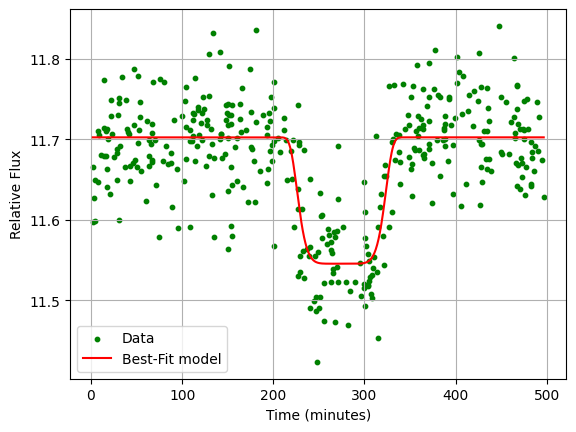

In [7]:
t_new = np.linspace(min(t), max(t), 1000)

Fo, dF, dt, to, n = best_fit.x

model_lc = light_curve(t_new, Fo, dF, dt, to, n)

plt.scatter(t, f, s=10, c='g', label='Data')
plt.plot(t_new, model_lc, c='r', label='Best-Fit model')
plt.xlabel('Time (minutes)')
plt.ylabel('Relative Flux')
plt.legend()
plt.grid()
plt.show()

8) Now we want to find the *conditional* posterior distribution for the central time $t_o$ with a uniform prior distribution.  

Set all the other parameters to the best-fit values you have already found.  Make a loop through possible $t_o$ s.  At each value calculate the $\chi^2$ and store it in an array.  Because the noise is Gaussian distributed, the log of the likelihood is

$\ln L (t_o,F_o,\delta F,\Delta t,n) = - \frac{1}{2} \chi^2(t_o,F_o,\delta F,\Delta t,n) + const.$

Use `np.trapz(L,x=tos)` to normalize the likelihood and plot it as a function of $t_o$.  Make sure you have used enough $t_o$s and a wide enough range that the integral is accurately calculated. 


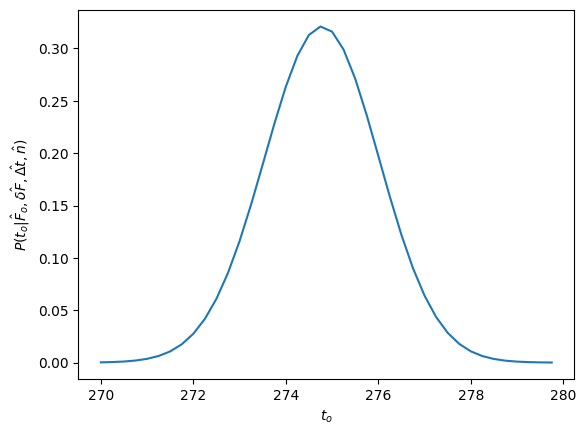

In [8]:
from copy import copy

p = copy(best_fit.x)
d = 0.25

tos = np.arange(270,280,d)
lnL = np.zeros(len(tos))
i=0
for tt in tos :
    p[3] = tt
    lnL[i] = -0.5 * chi2(p)
    i += 1

# normalize the likelihood to 1 using numpy.trapz() to do the integral 
L = np.exp(lnL)
L = L / np.trapezoid(L, x=tos)

plt.plot(tos,L)
plt.xlabel(r'$t_o$')
plt.ylabel(r'$P(t_o | \hat{F}_o,\hat{\delta F},\hat{\Delta t},\hat{n})$')
plt.show()

9) Calculate the mean and standard deviation of $P(t_o | \hat{F}_o,\hat{\delta F},\hat{\Delta t},\hat{n})$.  You should do this by approximating an integral over the pdf using numpy.trapz() the tabulated values for the pdf that you have found in 8).

Note that:

$P(t_o | \hat{F}_o,\hat{\delta F},\hat{\Delta t},\hat{n}) = P(t_o,\hat{F}_o,\hat{\delta F},\hat{\Delta t},\hat{n}) / P(\hat{F}_o,\hat{\delta F},\hat{\Delta t},\hat{n})$

$P(\hat{F}_o,\hat{\delta F},\hat{\Delta t},\hat{n})$ does not depend on $t_o$ so it is just a normalization constant that can be found numerically.

In [9]:
ave_to = np.trapezoid(tos * L, x=tos)
var_to = np.trapezoid(tos**2 * L, x=tos) - ave_to**2

print('to = ', ave_to, ' +/- ', np.sqrt(var_to))

to =  274.7683874957572  +/-  1.245197468318789


10) Do the same for $P(\delta F | \hat{\Delta t}, \hat{F}_o,\hat{t_o},\hat{n})$ including plotting it.

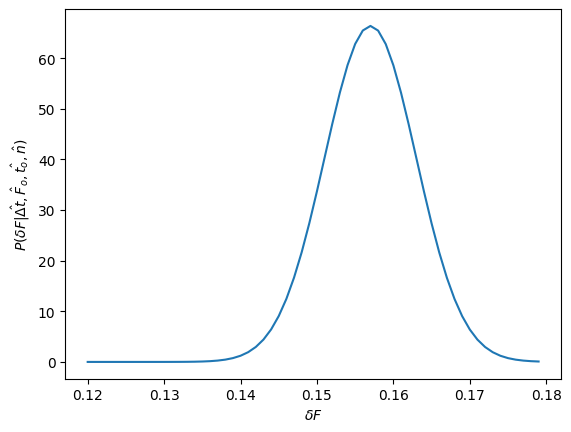

dF =  0.15699318990300504  +/-  0.00600608543732948


In [10]:

p = copy(best_fit.x)
d = 0.001
dFs = np.arange(0.12, 0.18, d)

lnL = np.zeros(len(dFs))
i = 0
for dF in dFs:
    p[1] = dF
    lnL[i] = -0.5 * chi2(p)
    i += 1

L = np.exp(lnL - np.max(lnL))
L = L / np.trapezoid(L, x=dFs)

plt.plot(dFs, L)
plt.xlabel(r'$\delta F$')
plt.ylabel(r'$P(\delta F | \hat{\Delta t}, \hat{F}_o,\hat{t_o},\hat{n})$')
plt.show()

ave_dF = np.trapezoid(dFs * L, x=dFs)
var_dF = np.trapezoid(dFs**2 * L, x=dFs) - ave_dF**2

print('dF = ',ave_dF,' +/- ',np.sqrt(var_dF))

11) Do the same for $P(\Delta t | \hat{F}_o,\hat{\delta F},\hat{t_o},\hat{n})$.

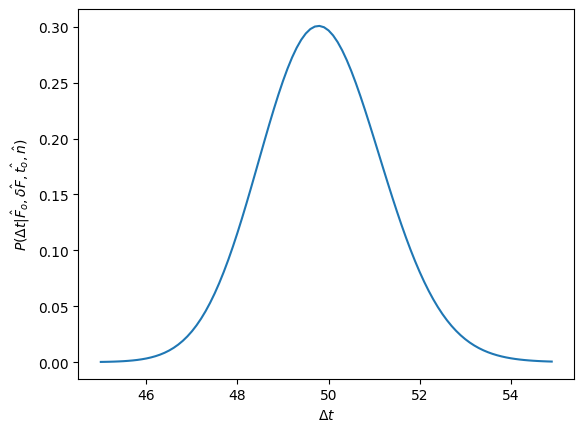

Delta t =  49.858561418484484  +/-  1.3295762926453976


In [11]:
p = best_fit.x
d = 0.1
dts = np.arange(45, 55, d)

lnL = np.zeros(len(dts))
i = 0
for dt in dts:
   p[2] = dt
   lnL[i] = -0.5 * chi2(p)
   i += 1


L = np.exp(lnL - np.max(lnL))
L = L / np.trapezoid(L, x=dts)

plt.plot(dts, L)
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'$P(\Delta t | \hat{F}_o,\hat{\delta F},\hat{t_o},\hat{n})$')
plt.show()

ave_dt = np.trapezoid(dts * L, x=dts)
var_dt = np.trapezoid(dts**2 * L, x=dts) - ave_dt**2

print('Delta t = ',ave_dt,' +/- ',np.sqrt(var_dt))

12) Now we want to find the posterior *marginalized over* $t_o$.  This involves integrating over $t_o$ for each value of $\delta F$ and $\Delta t$ :

$P(\delta F,\Delta t | \hat{F}_o,\hat{n}) = \int dt_o~ P(\delta F,\Delta t, t_o | \hat{F}_o,\hat{n})$

We will keep $F_o$ and $n$ fixed to their best-fit values $\hat{F}_o$ and $\hat{n}$ to make things simpler.

Make two nested loops over $\delta F$ and $\Delta t$ within which the likelihood is integrated over $t_o$.  To do this we must define a function that can be integrated by `scipy.integrate.quad`.  The first argument of this function is the variable over which the integral and the second is the other parameters.

These likelihoods should be stored in a 2-dimensional array `L[i,j]`.  Then make a contour plot of $L$.  This calculation might take a while.  If it takes too long you can reduce the resolution in $\delta F$ and $\Delta t$.


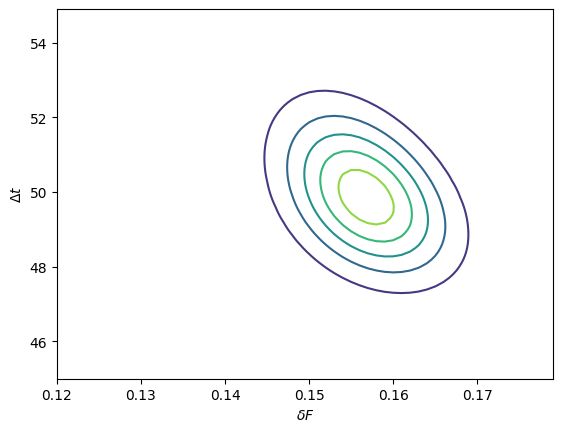

In [12]:
from scipy.integrate import quad

def integrand3(t_o, p):
    p[3] = t_o
    return np.exp(-0.5*chi2(p))


p = copy(best_fit.x)
L = np.zeros([len(dts), len(dFs)])
j = 0
for dF in dFs:
    i = 0
    for dt in dts:
        p[1] = dF
        p[2] = dt
        L[i, j] = quad(integrand3, 270, 320, args=p)[0]
        i += 1
    j += 1

plt.contour(dFs, dts, L)
plt.xlabel(r'$\delta F$')
plt.ylabel(r'$\Delta t$')
plt.show()

So far we have calculated the un-normalized posterior.  We need to find the contours in parameter space that contain 68%, 95%, and 99% of the posterior probability.

Here is a function which, given a tabulated distribution distribution `posterior` and a fraction, will return the contour level within which that fraction of the distribution is contained.  For example, The contour within which half of the probability is contained would be `find_level(probability_table,0.5)[0]`.  The function assumes that the `probability_table` is evaluated on a uniform (in prior probability) grid.

In [13]:
def find_level(prob,fraction) :
    '''
    this function finds the level for a 
    contour that contains a fixed fraction  
    of the total sum of pixels
    '''
    tot = np.sum(prob)
    max = np.max(prob)
    min = np.min(prob)

    level = 0.5*(max + min)
    frac = np.sum( prob[ prob >= level ]  )/tot
    res = np.min( prob[ prob >= level ]  )/tot

    while( abs(frac - fraction) > res  ) :
        
        if( frac > fraction) :
            min = level
        else :
            max = level
            
        level = 0.5*(max + min)
            
        frac = np.sum( prob[ prob >= level ] )/tot
        res = np.min( prob[ prob >= level ]  )/tot

    return level,frac

13) Make a credibility plot (contour plot of the marginalized posterior) for $\delta F$-$\Delta t$ with 68%, 95% and 99% contours.  The function above can be used to find the levels.

[np.float64(9.474277195333222e-90), np.float64(4.26863038469943e-89), np.float64(2.72359441130895e-88)]


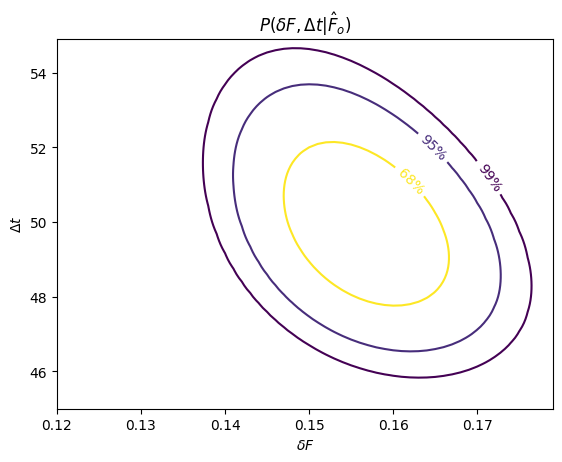

In [14]:
level68 = find_level(L, 0.68)[0]
level95 = find_level(L, 0.95)[0]
level99 = find_level(L, 0.99)[0]

levs = [level99 , level95, level68]

print(levs)

fig, ax = plt.subplots()
CS = ax.contour(dFs, dts, L, levs)
## the stupidly complicated way contours are labeled 
fmt = {}
strs = ['99%', '95%', '68%']
for i, s in zip(CS.levels, strs):
    fmt[i] = s
ax.clabel(CS, inline=True, fontsize=10, fmt=fmt)

plt.xlabel(r'$\delta F$')
plt.ylabel(r'$\Delta t$')
plt.title(r'$P(\delta F,\Delta t | \hat{F}_o)$')
plt.show()

14) What is the ratio of the star's radius to the planet's radius?  Use the maximun likelihood values for $F_o$ and $\delta F$.


Answer: $$\frac{ dF}{F_0} \propto \left( \frac{R_p}{R_*} \right)^2$$

In [15]:
# A planet in front of its star will block an amount of stellar flux roughly proportional to its surface area.
# Hence the drop in the star's flux d𝐹 is proportional to the ratio of planet to stellar radius squared. (check above formula)

Fo = best_fit.x[0]
dF = best_fit.x[1]
radius_ratio = np.sqrt(Fo / dF)

print(f"Ratio of star radius to planet radius (R*/Rp) = {radius_ratio:.2f}")

Ratio of star radius to planet radius (R*/Rp) = 8.63
